In [ ]:
import torch, torchvision

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm as tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision import models

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2024-12-01 16:18:50--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  34.5MB/s    in 9.2s    

2024-12-01 16:19:00 (28.8 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [ ]:
def load_images(img_path, resize=True):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found or failed to load: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (224, 224))
    return img

In [ ]:
def show_images(img_paths):
    img = load_images(img_paths)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_images(image_path) for image_path in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=10)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

<ipython-input-9-c06edebee33f>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  images = torch.as_tensor(images)


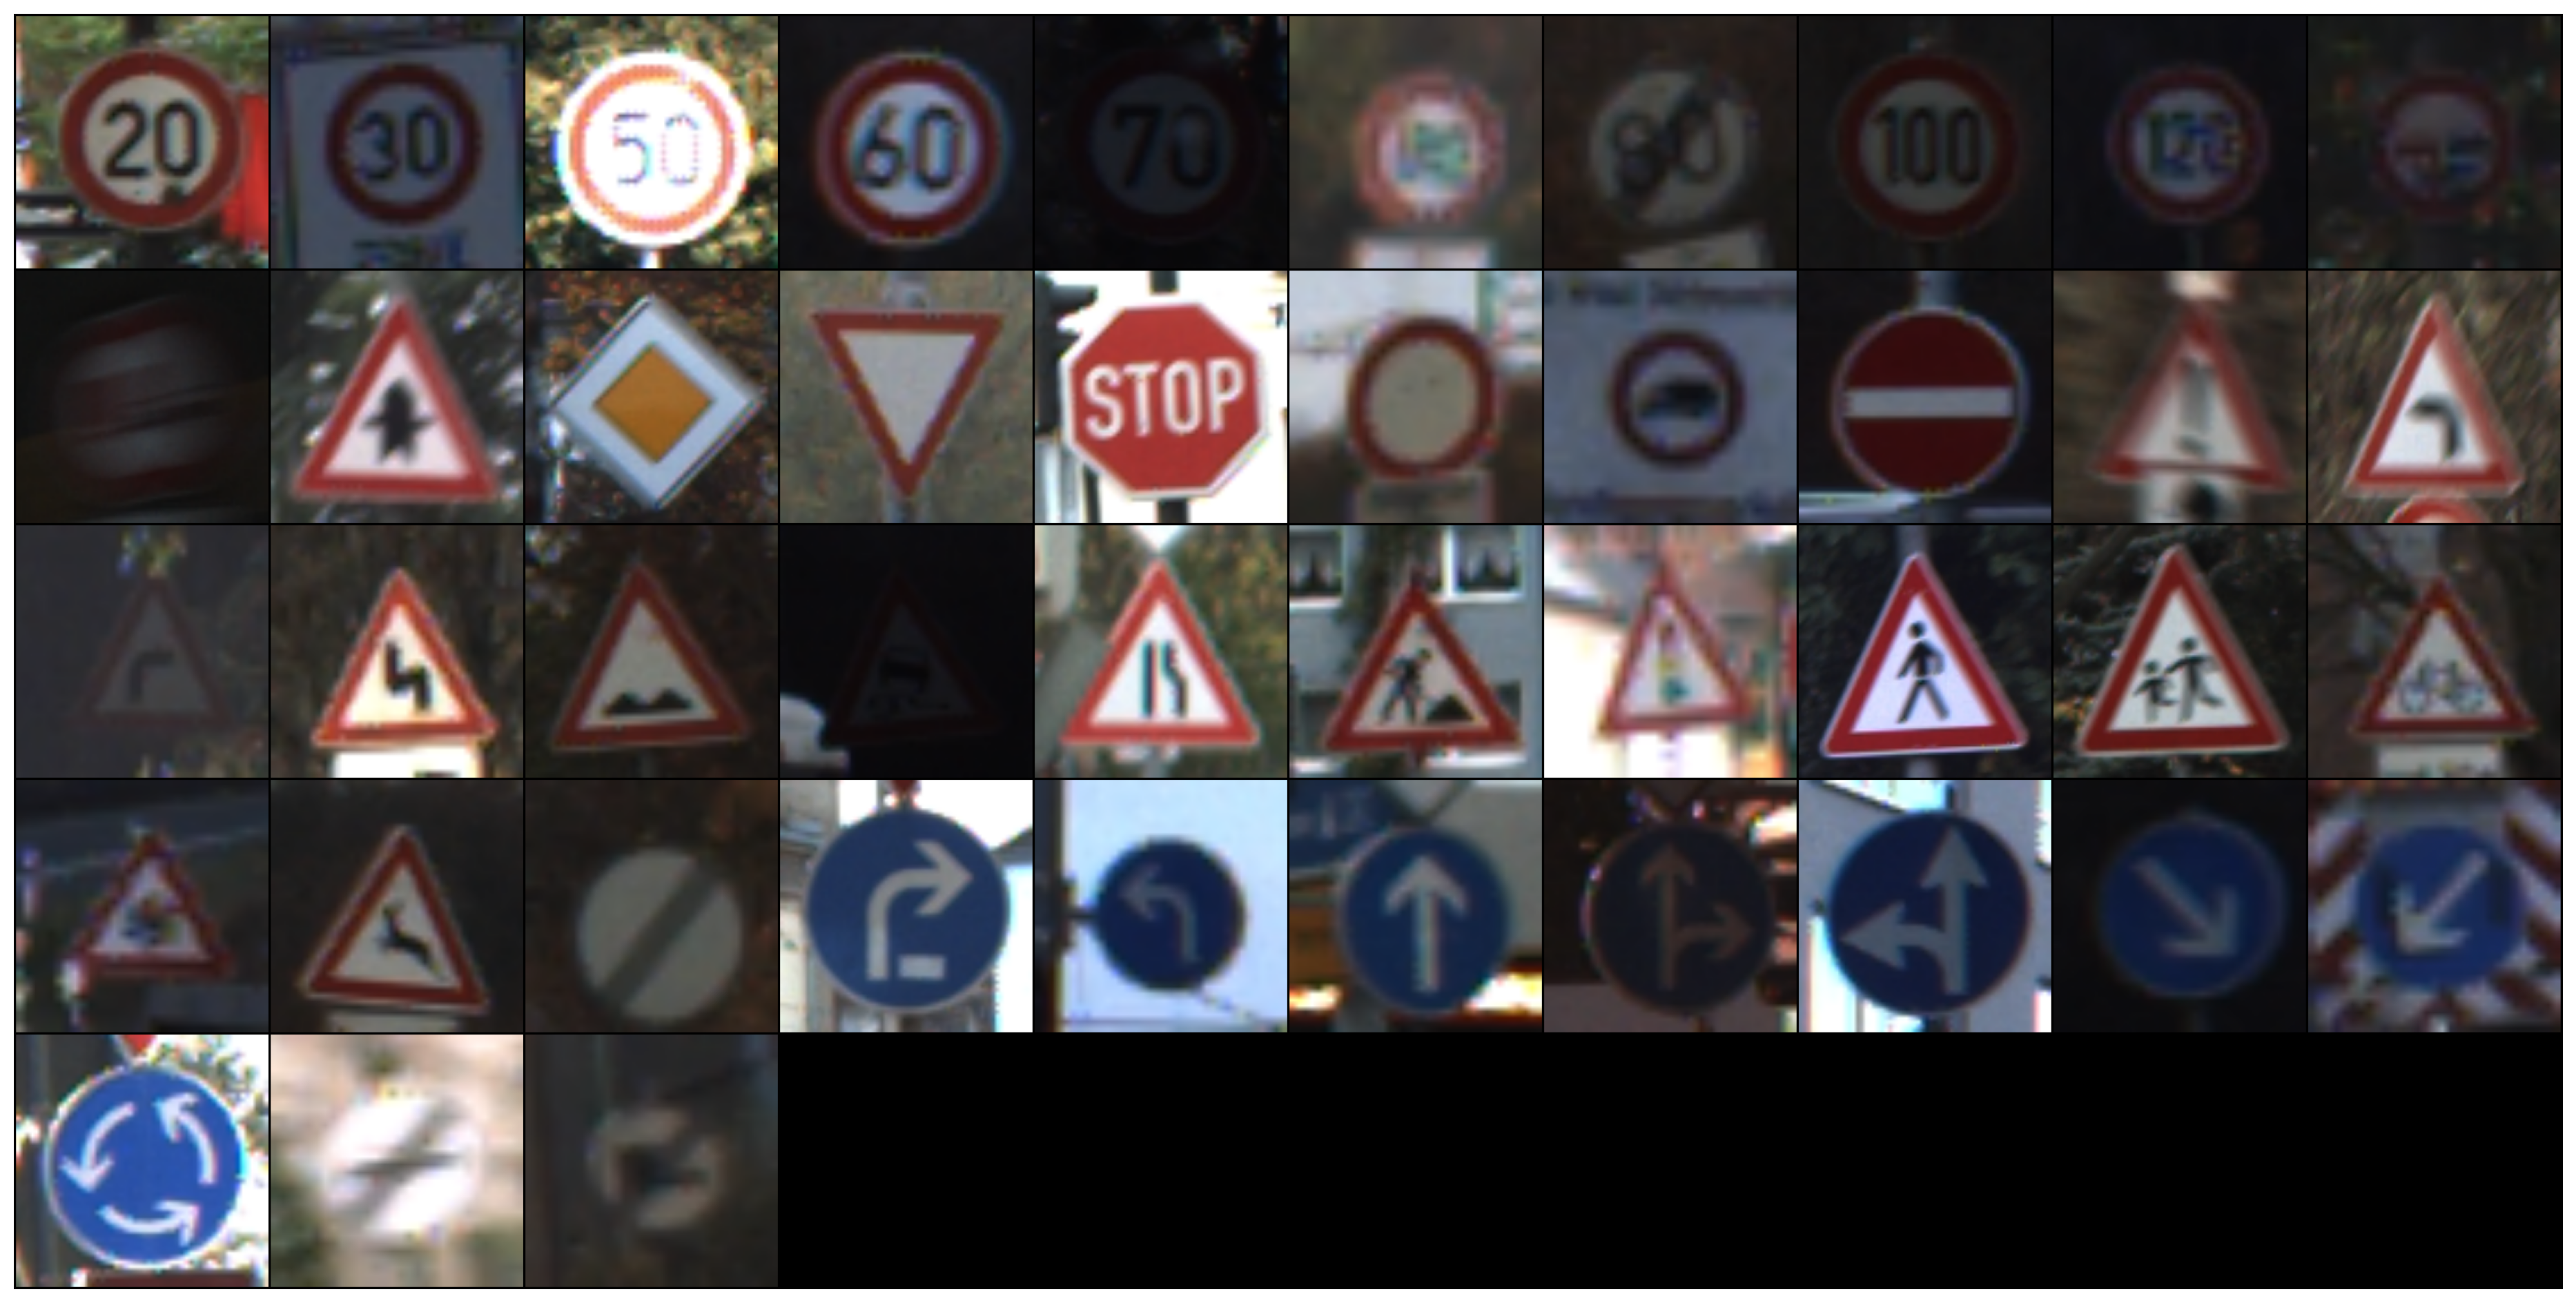

In [ ]:
sample_images = [np.random.choice(glob(train_folder + '/*.ppm')) for train_folder in train_folders]
show_sign_grid(sample_images)

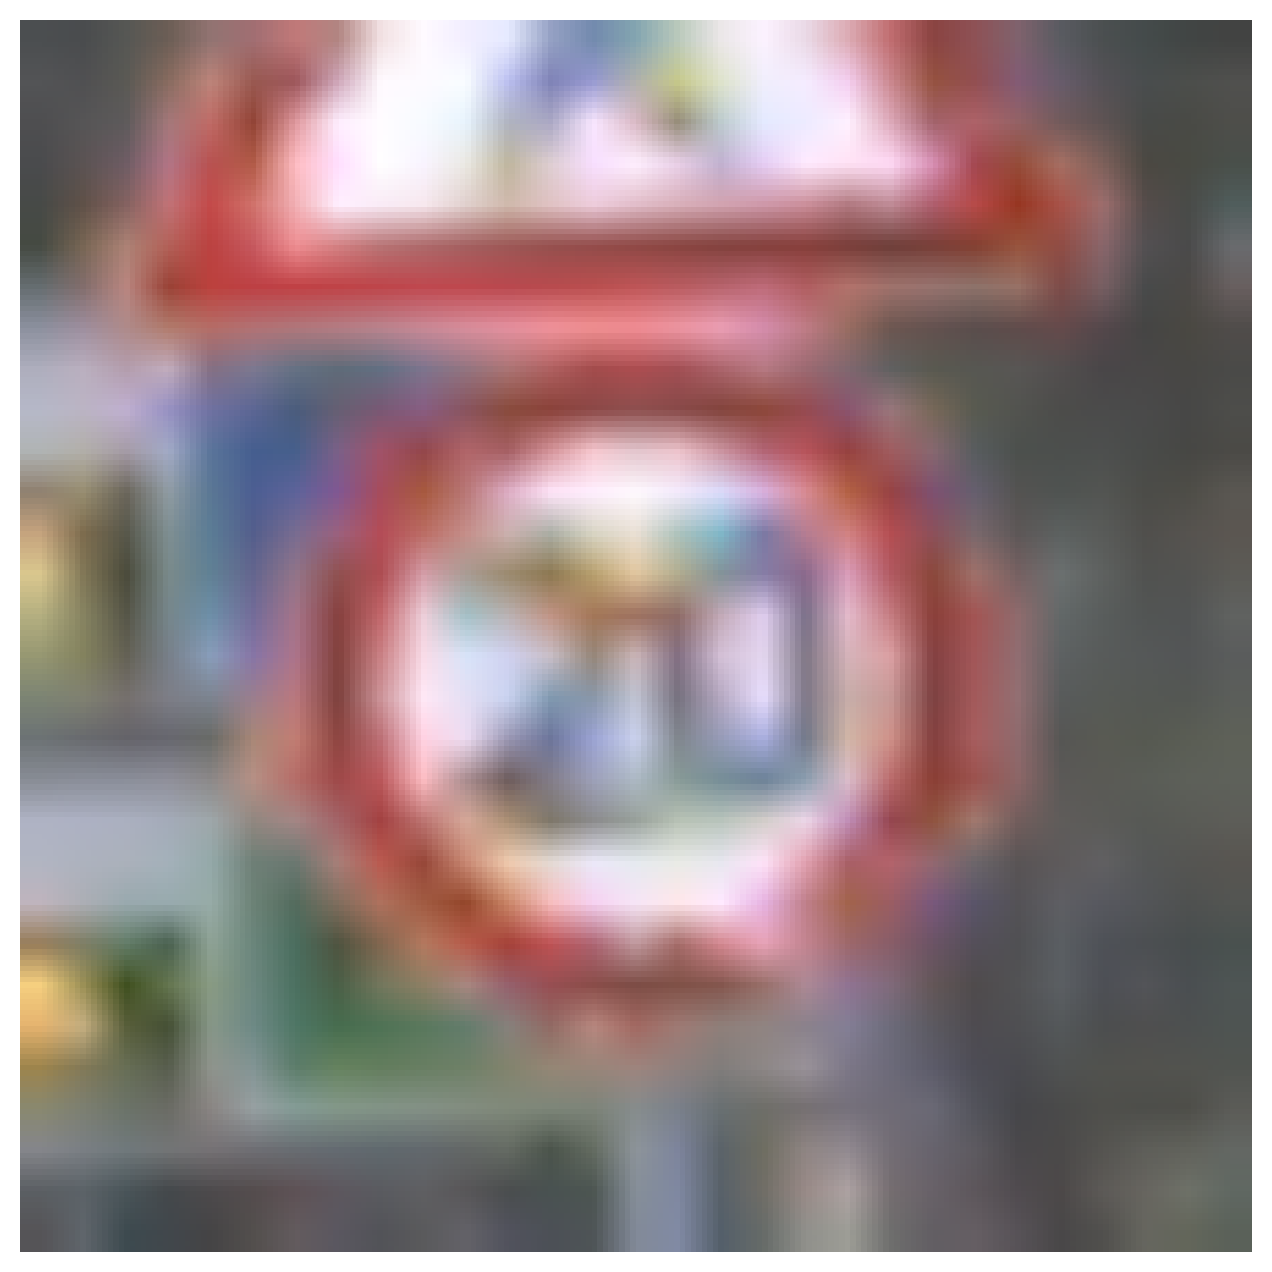

In [ ]:
img_path = '/content/GTSRB/Final_Training/Images/00000/00000_00000.ppm'
show_images(img_path)

In [ ]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [12, 13, 14, 17]

In [ ]:
! mkdir data

In [ ]:
data_dir = Path('data')

In [ ]:
Datasets = ["train", "valid", "test"]

for ds in Datasets:
    for cls in class_names:
        (data_dir / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')

    np.random.shuffle(image_paths)
    ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))])

    dataset_data = zip(Datasets, ds_split)
    for ds, split in dataset_data:
        for img_path in split:
            shutil.copy(img_path, data_dir / ds / class_name)

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [ ]:
### image augmantation techniques

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
    ]), 'valid': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
    ]), 'test': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
    ]),
  }

In [ ]:
image_datasets = {d: ImageFolder(f'{data_dir}/{d}', transforms[d]) for d in Datasets}

In [ ]:
data_loaders = {d: torch.utils.data.DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in Datasets}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 4920
     Root location: data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 615
     Root location: data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 615
     Root loca

In [ ]:
data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7cda1dd31f00>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7cda1dd32b30>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7cda1dd31510>}

In [ ]:
datasets_sizes = {d: len(image_datasets[d]) for d in Datasets}
class_names = image_datasets['train'].classes

datasets_sizes

{'train': 4920, 'valid': 615, 'test': 615}

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
      plt.title(title)

    plt.axis('off')

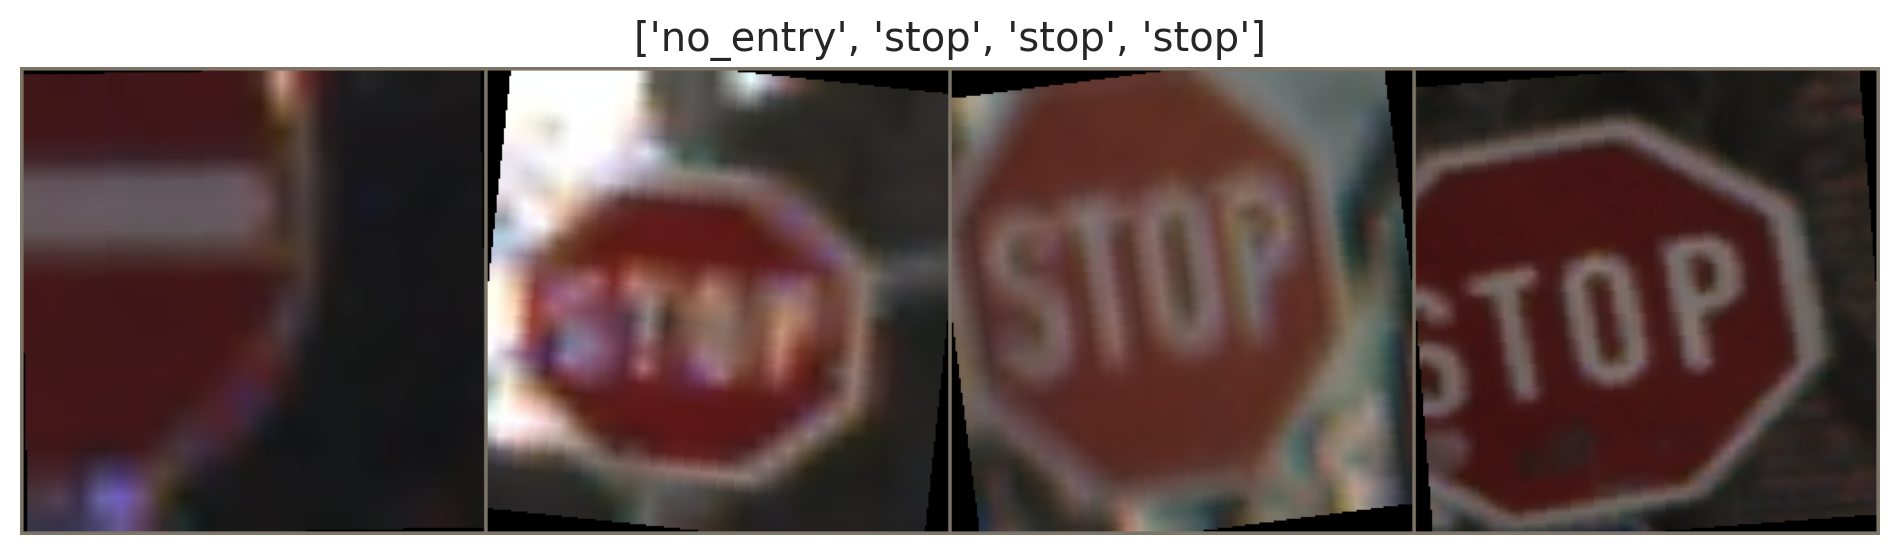

In [ ]:
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def create_model(num_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, num_classes)
  return model.to(device)

In [ ]:
base_model = create_model(num_classes=4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 52.6MB/s]


In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for inputs, labels in tqdm.tqdm(dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)

    losses.append(loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, dataloader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in tqdm.tqdm(dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, dataloaders_dict, device, num_epochs):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_acc = 0.0
  best_epoch = 0

  for epoch in range(num_epochs):
    print(f"epoch {epoch + 1}/{num_epochs}")
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, dataloaders_dict['train'], loss_fn, optimizer, device, scheduler, datasets_sizes['train'])
    valid_acc, valid_loss = eval_model(model, dataloaders_dict['valid'], loss_fn, device, datasets_sizes['valid'])

    print(f'train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
    print(f'valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['valid_acc'].append(valid_acc)
    history['valid_loss'].append(valid_loss)

    if valid_acc > best_acc:
      best_acc = valid_acc
      best_epoch = epoch + 1

      torch.save(model.state_dict(), 'best_model_state.bin')
  print(f'best valid acc: {best_acc}, best epoch: {best_epoch}')

  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, device, num_epochs=10)

epoch 1/10
----------


100%|██████████| 154/154 [01:52<00:00,  1.37it/s]


train loss: 0.3303, train acc: 0.8858
valid loss: 0.0087, valid acc: 0.9984

epoch 2/10
----------


 94%|█████████▎| 1153/1230 [56:47<03:41,  2.87s/it]

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['valid_loss'], label='valid loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.set_title('loss history')
  ax1.legend()

  ax2.plot(history['train_acc'], label='train acc')
  ax2.plot(history['valid_acc'], label='valid acc')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_title('accuracy history')
  ax2.legend()

  fig.suptitle('training history')
  plt.show()

plot_training_history(history)

In [ ]:
base_model.load_state_dict(torch.load('best_model_state.bin'))

In [ ]:
def show_predictions(model, class_names, n=6):
    model = model.eval()
    images_handled = 0
    plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handled += 1
                ax = plt.subplot(n, n, images_handled)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}', fontsize=8)  # Smaller font
                imshow(inputs.cpu().data[j])

                if images_handled == n * n:
                    return

In [ ]:
show_predictions(base_model, class_names, n=8)

In [ ]:
def get_predictions(model, dataloader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt='', cmap='Blues')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
#### check the reall world images

! gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

In [ ]:
show_images('stop-sign.jpg')

In [ ]:
## check for the confidence of each class

def predict_proba(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = transforms['test'](img).unsqueeze(0)

    pred = model(img.to(device))
    print(pred)
    pred = F.softmax(pred, dim=1)
    return pred.detach().cpu().numpy()

In [ ]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

In [ ]:
pred_df = pd.DataFrame(pred, columns=class_names)
pred_df

In [ ]:
sns.barplot(x="values", y="class_name", data=pred_df.melt(var_name="class_name", value_name="values"))
plt.xlim([0, 1])


In [ ]:
### the traffic sign which never seen before

! gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

In [ ]:
show_images('unknown-sign.jpg')

In [ ]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

In [ ]:
pred_df = pd.DataFrame(pred, columns=class_names)
pred_df

In [ ]:
sns.barplot(x="values", y="class_name", data=pred_df.melt(var_name="class_name", value_name="values"))
plt.xlim([0, 1])

In [ ]:
## the sbove result is wrong
#### so we need to add a class of unknown for this one

unknown_indices = [
    i for i, f in enumerate(train_folders) if i not in class_indices
]

len(unknown_indices)

In [ ]:
for ds in Datasets:
    (data_dir / ds / 'unknown').mkdir(parents=True, exist_ok=True)

    for ui in unknown_indices:
        image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
        image_paths = np.random.choice(image_paths, 50)

        ds_split = np.split(image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))])

        dataset_data = zip(Datasets, ds_split)
        for ds, split in dataset_data:
            for img_path in split:
                shutil.copy(img_path, data_dir / ds / 'unknown')

In [ ]:
image_datasets = {d: ImageFolder(f'{data_dir}/{d}', transforms[d]) for d in Datasets}
data_loaders = {d: torch.utils.data.DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in Datasets}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in Datasets}
class_names = image_datasets['train'].classes
dataset_sizes

In [ ]:
%%time

enhanced_model = create_model(num_classes=5)
enhanced_model, history = train_model(enhanced_model, data_loaders, dataset_sizes, device)

In [ ]:
plot_training_history(history)

In [ ]:
show_images('unknown-sign.jpg')

In [ ]:
pred = predict_proba(enhanced_model, 'unknown-sign.jpg')
show_prediction_confidence(enhanced_model, class_names)

In [ ]:
show_predictions(enhanced_model, class_names, n_images=8)

In [ ]:
y_pred, y_rest = get_predictions(enhanced_model, data_loaders['test'])

print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)